This notebook analyzes the Boulder dataset from NIST linked https://nextg.nist.gov/submissions/112. The first half of the notebook is from tutorial #5 to process the data. 

In [109]:
import glob
from scipy.io import loadmat

import os
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random

import sys

sys.path.append(os.path.abspath('./src'))
from scene_generation.core import Scene
from scene_generation.utils import rect_from_point_and_size, get_utm_epsg_code_from_gps, gps_to_utm_xy, get_center_subarray
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

In [110]:
# LOS or NLOS for measurement type
MEASUREMENT_TYPE = "NLOS"

In [111]:
# Initialize header data structure
header_dict = {"file_name":[], "mea_idx":[]}
header_folder_path = "./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/Header files/".format(MEASUREMENT_TYPE)  
header_mat_files = glob.glob(f"{header_folder_path}/*.mat")  
print(header_mat_files[:3]) 

['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002150hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002142hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002174hdr.mat']


In [112]:
# MATLAB to Python data conversion
for mat_file_path in header_mat_files: 

    #Load the .mat file
    data = loadmat(mat_file_path)

    # Store basic file info
    header_dict["file_name"].append(os.path.basename(mat_file_path))
    header_dict["mea_idx"].append(os.path.basename(mat_file_path)[4:4+4])

    # Recursive struct parsing
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in header_dict:
                            header_dict[("{}_{}".format(key, name))] = []
                        header_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in header_dict:
                    header_dict[("{}".format(key))] = []
                header_dict[("{}".format(key))].append(tmp_value)

In [113]:
header_df = pd.DataFrame(header_dict)
# print(header_df.iloc[0].to_string())

In [114]:
assert header_df['TxData_lat_Deg'].nunique() == 1,"Error: Mupltiple TX latitudes detected"
assert header_df['TxData_long_Deg'].nunique() == 1,"Error: Mupltiple TX longitudes detected" 
assert header_df['TxData_alt'].nunique() == 1,"Error: Mupltiple TX altitudes detected" 

In [115]:
# Initialize MPC data structure
MPC_dict = {"file_name":[],"mea_idx":[]}
MPC_folder_path = "./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/MPC files/".format(MEASUREMENT_TYPE)  
MPC_mat_files = glob.glob(f"{MPC_folder_path}/*.mat")  

#print(MPC_mat_files[:3]) 

In [116]:
for mat_file_path in MPC_mat_files:   
    data = loadmat(mat_file_path)
    MPC_dict["file_name"].append(os.path.basename(mat_file_path))
    MPC_dict["mea_idx"].append(os.path.basename(mat_file_path)[3:3+4])
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in MPC_dict:
                            MPC_dict[("{}_{}".format(key, name))] = []
                        MPC_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in MPC_dict:
                    MPC_dict[("{}".format(key))] = []
                MPC_dict[("{}".format(key))].append(tmp_value)

In [117]:
MPC_df = pd.DataFrame(MPC_dict)
print(MPC_df.iloc[0].to_string())
print("\n")
# print(MPC_df.iloc[0]["MPC_params_sector01"])

file_name                                                            MPC2266.mat
mea_idx                                                                     2266
header_TxGainEffective_dBi                                                     2
header_TxHPBW_Effective_deg                                                 47.3
header_dist_m                                                          61.906189
header_NumSectors                                                              8
header_B2B_Attenuation_dB                                                    -15
MPC_params_sector01            [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02            [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03            [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04            [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05            [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_sector06         

In [118]:
merged_df = pd.merge(MPC_df, header_df, on='mea_idx', how='inner')  
print(merged_df.iloc[0].to_string())

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

In [119]:
for mat_file_path in MPC_mat_files:   
    data = loadmat(mat_file_path)
    MPC_dict["file_name"].append(os.path.basename(mat_file_path))
    MPC_dict["mea_idx"].append(os.path.basename(mat_file_path)[3:3+4])
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in MPC_dict:
                            MPC_dict[("{}_{}".format(key, name))] = []
                        MPC_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in MPC_dict:
                    MPC_dict[("{}".format(key))] = []
                MPC_dict[("{}".format(key))].append(tmp_value)

In [120]:
MPC_df = pd.DataFrame(MPC_dict)
print(MPC_df.iloc[0].to_string())
print("\n")

file_name                                                            MPC2266.mat
mea_idx                                                                     2266
header_TxGainEffective_dBi                                                     2
header_TxHPBW_Effective_deg                                                 47.3
header_dist_m                                                          61.906189
header_NumSectors                                                              8
header_B2B_Attenuation_dB                                                    -15
MPC_params_sector01            [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02            [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03            [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04            [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05            [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_sector06         

In [121]:
merged_df = pd.merge(MPC_df, header_df, on='mea_idx', how='inner')  
print(merged_df.iloc[0].to_string())

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

In [122]:
scene_dir = "./scenes/Boulder_Downtown"

polygon_points_gps = rect_from_point_and_size(
    merged_df.iloc[0]["TxData_long_Deg"],
    merged_df.iloc[0]["TxData_lat_Deg"],
    "center", 
    512,
    512
)
min_lon, min_lat = polygon_points_gps[0]
max_lon, max_lat = polygon_points_gps[2]
print(
    f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
)
scene_instance = Scene()
scene_instance(
    polygon_points_gps,
    scene_dir,
    None,
    osm_server_addr="https://overpass-api.de/api/interpreter",
    lidar_calibration=False,
    generate_building_map=True,
    ground_material_type="mat-itu_concrete",
    rooftop_material_type = "mat-itu_metal",
    wall_material_type = "mat-itu_brick"
    
)

utm_epsg = get_utm_epsg_code_from_gps(
    merged_df.iloc[0]["TxData_long_Deg"],
    merged_df.iloc[0]["TxData_lat_Deg"],
)

top_left_coord_x_utm, top_left_coord_y_utm,_  =  gps_to_utm_xy(min_lon, max_lat, utm_epsg)
center_coord_x_utm, center_coord_y_utm, _ = gps_to_utm_xy(
    merged_df.iloc[0]["TxData_long_Deg"],
    merged_df.iloc[0]["TxData_lat_Deg"], 
    utm_epsg
)

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 591.46it/s]


In [123]:
scene = load_scene("{}/scene.xml".format(scene_dir))

2025-08-12 00:17:51 WARN wrk3 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

In [124]:
# Apply transformation and store in new columns
merged_df["GPSData_longitude_UTM"], merged_df["GPSData_latitude_UTM"], _ = zip(
    *merged_df.apply(lambda row: gps_to_utm_xy(row["GPSData_longitude_Deg"], row["GPSData_latitude_Deg"], utm_epsg), axis=1)
)

merged_df["Sionna_Rx_x"], merged_df["Sionna_Rx_y"] = zip(
    *merged_df.apply(lambda row: (row["GPSData_longitude_UTM"] - center_coord_x_utm, row["GPSData_latitude_UTM"] - center_coord_y_utm ), axis=1)
)

print(merged_df.iloc[0].to_string())

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

In [125]:
merged_df = merged_df.drop_duplicates(subset=['mea_idx'])

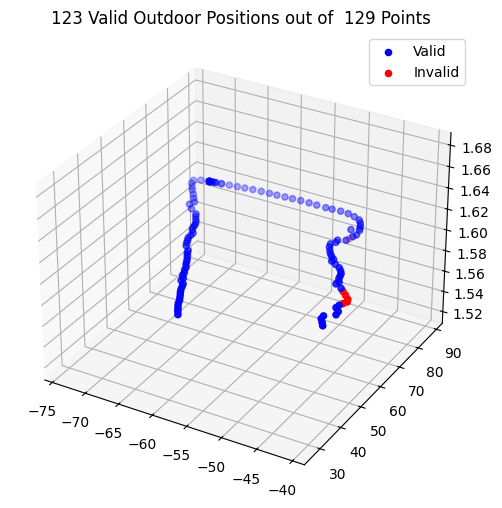

In [126]:
# Obtain the Mitsuba scene object from Sionna scene object 
mi_scene = scene.mi_scene

# Calculate scene bounding box excluding the ground plane
bbox = mi.ScalarBoundingBox3f()
for shape in mi_scene.shapes():
    if "ground" not in shape.id():
        bbox.expand(shape.bbox())

# Generate candidate positions (with a typical UE height of 1.5m)
# num_candidates = 1000
candidates = np.column_stack([
    merged_df["Sionna_Rx_x"].to_numpy(),
    merged_df["Sionna_Rx_y"].to_numpy(),
    merged_df["RxData_Rxh_m"].to_numpy()
])

# Create a direction vector pointing upwards (towards the sky) 
#  and tile it to match the number of positions
directions_np = np.tile(np.array([0, 0, 1]), (len(merged_df), 1))

# Ray tracing validation
rays = mi.Ray3f(
    # mi.Vector3f(candidates),
    mi.Vector3f(np.array(candidates, dtype=np.float32).T),
    mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
)
si = mi_scene.ray_intersect(rays)
valid_mask = ~si.is_valid()

merged_df["is_outdoor"] = valid_mask

# Filter and visualize
valid_positions = candidates[valid_mask]
invalid_positions = candidates[~valid_mask]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2],c="blue",label="Valid")
ax.scatter(invalid_positions[:,0], invalid_positions[:,1], invalid_positions[:,2], c="red", label="Invalid" )
# Add legend
ax.legend()
ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions out of  {len(merged_df)} Points")
plt.show()

In [127]:
# Transmitter array (single isotropic element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="V"
)

# Transmitter configuration
tx = Transmitter(
    name="tx",
    position=[0, 0, float(merged_df.iloc[0]["TxData_Txh_m"])],  # Elevated position
    orientation=[0, 0, 0]  
)
scene.add(tx)

# Select 10 receivers form valid_positions (Outdoor positions)
# // for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=5, replace=False)]):
for index, row in merged_df.iterrows():
    if merged_df.iloc[index]['is_outdoor'] == True:
        rx = Receiver(
                name=f"rx_{row['mea_idx']}",
                position=(row["Sionna_Rx_x"], row["Sionna_Rx_y"] , row["RxData_Rxh_m"]),
                orientation=[0, 0, 0] 
            )
        scene.add(rx)
        

In [128]:
# Configure simulation parameters
scene.frequency = 28.5e9  
scene.synthetic_array = True  # Optimize for array calculations

for radio_material in scene.radio_materials.values():
    radio_material.scattering_coefficient  = 0.4

# Perform ray tracing using PathSolver()
solver = PathSolver()
paths = solver(scene, 
               max_depth=2,
               los=True,
               specular_reflection=True,
               diffuse_reflection=True, 
               refraction=False,
               samples_per_src=int(1e3)
)

In [129]:
# Preview the scene with paths
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [130]:
# Parse paths into a structured dataset containing detailed rays information
def create_ray_dataset(paths, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        'rx_coord':[]
    }

    # See sionna.rt.constants.InteractionType
    ray_type_map = {0: "LOS", 1: "SPECULAR", 2: "DIFFUSE", 4: "REFRACTION"}
    
    a = np.asarray(paths.a).squeeze()
    tau = np.asarray(paths.tau).squeeze()
    types = np.asarray(paths.interactions).squeeze()
    mask = np.asarray(paths.valid).squeeze()
    phi_r = np.asarray(paths.phi_r).squeeze()
    phi_t = np.asarray(paths.phi_t).squeeze()
    theta_r = np.asarray(paths.theta_r).squeeze()
    theta_t = np.asarray(paths.theta_t).squeeze()
    targets = np.asarray(paths.targets).squeeze().T
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        # Filter out the RX if it has no valid paths
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    cur_ray_type = 0
                    num_depths = types.shape[0]
                    for depth_idx in range(num_depths-1, -1, -1):
                        cur_ray_type = types[depth_idx,idx,sub_idx]
                        # print(f"types[{depth_idx},{idx},{sub_idx}]",cur_ray_type)
                        if cur_ray_type != 0:
                            break

                    # Store the list instead of np.array to avoid the space seperator in .csv
                    dataset["freq"].append(frequency)
                    dataset["type"].append(ray_type_map[cur_ray_type])
                    z = np.complex64(a[0,idx,sub_idx] + 1j*a[1, idx,sub_idx]) 
                    dataset["a"].append(z)
                    dataset["tau"].append(tau[idx,sub_idx])

                    # Paths object only store the RX position instead of the name/idx of the RX in the Scenes Object
                    # We need to obtain the RX name by calculating the nearest RX pos due to the precision issue
                    nearest_row = merged_df.loc[
                        merged_df.apply(lambda row: (row['Sionna_Rx_x'] - targets[idx, 0])**2 + (row['Sionna_Rx_y'] - targets[idx, 1])**2, axis=1).idxmin()
                    ]
                    dataset["rx_id"].append(nearest_row["mea_idx"])
                
                    
                    dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])                    
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
    
    return pd.DataFrame(dataset)

# Generate analysis dataframe
df = create_ray_dataset(paths, frequency=28.5e9)
df.head(10)

freq rx_id      type     phi_r     phi_t   theta_r   theta_t  \
0  2.850000e+10  2266   DIFFUSE -1.043383 -1.561312  1.564748  1.720504   
1  2.850000e+10  2266   DIFFUSE -1.099824 -1.707117  1.449318  1.291920   
2  2.850000e+10  2266   DIFFUSE  1.277036  2.774233  0.500176  1.485608   
3  2.850000e+10  2266  SPECULAR -1.803277  1.338316  1.695591  1.695593   
4  2.850000e+10  2266   DIFFUSE -1.138958 -2.344270  1.596003  1.684152   
5  2.850000e+10  2266   DIFFUSE -1.077254  3.022210  1.606511  1.690199   
6  2.850000e+10  2266  SPECULAR -1.585958  1.555635  1.743483  1.743483   
7  2.850000e+10  2266   DIFFUSE -0.968761 -2.395356  1.597535  1.795916   
8  2.850000e+10  2266   DIFFUSE -1.243879 -1.860375  1.588510  1.625879   
9  2.850000e+10  2266   DIFFUSE -0.906315 -1.148016  1.427475  2.082301   

                                                a           tau  \
0 -1.051829e-07-2.738504e-                    09j  3.824715e-07   
1  3.508752e-07+0.000000e+                    00j  3.892301e-07   
2 -3.178333e-07+1.253023e-                    07j  3.501193e-07   
3 -2.018855e-07-4.168371e-                    09j  3.325144e-07   
4  8.929052e-08+0.000000e+                    00j  2.852785e-07   
5  1.455926e-07+0.000000e+                    00j  2.192902e-07   
6 -3.969483e-08-1.261509e-                    09j  5.114877e-07   
7  4.808095e-08+0.000000e+                    00j  2.368800e-07   
8  7.221235e-08+0.000000e+                    00j  4.520372e-07   
9  2.127095e-08-3.468412e-                    09j  4.101348e-07   

                                        rx_coord  
0  [-41.878291736589745, 41.86986129079014, 1.6]  
1  [-41.878291736589745, 41.86986129079014, 1.6]  
2  [-41.878291736589745, 41.86986129079014, 1.6]  
3  [-41.878291736589745, 41.86986129079014, 1.6]  
4  [-41.878291736589745, 41.86986129079014, 1.6]  
5  [-41.878291736589745, 41.86986129079014, 1.6]  
6  [-41.878291736589745, 41.86986129079014, 1.6]  
7  [-41.878291736589745, 41.86986129079014, 1.6]  
8  [-41.878291736589745, 41.86986129079014, 1.6]  
9  [-41.878291736589745, 41.86986129079014, 1.6]

In [131]:
def linear(pg_arr):
    pg_arr_copy = pg_arr.copy()
    return 10 ** (pg_arr_copy / 10)

def convert_to_db(pg_arr):
    pg_arr_copy = pg_arr.copy()
    return 10 * np.log10(pg_arr_copy)

def normalize(path_gain_arr):
    linear_pg = linear(path_gain_arr)
    max_val = np.max(linear_pg)
    linear_pg_norm = linear_pg / max_val
    return convert_to_db(linear_pg_norm)

In [132]:
def compare_real_vs_sionna(
    aoa_az_real,
    aoa_az_sionna,
    aoa_el_real,
    aoa_el_sionna,
    delay_real,
    delay_sionna,
    pg_real,
    pg_sionna,
    rx_id,
    norm_threshold
):
    fig = plt.figure(figsize=(14, 12))  # Adjust size as needed
    fig.suptitle(f'RX-{rx_id}', fontsize=16, fontweight='bold')

    # Plot 1: AoA Azimuth - Real
    ax1 = fig.add_subplot(3, 2, 1, polar=True)
    sc1 = ax1.scatter(np.deg2rad(aoa_az_real), pg_real, c=pg_real, cmap='viridis', s=50)
    ax1.set_ylim(max(pg_real), min(pg_real))
    ax1.set_title("AoA Azimuth - Real")
    plt.colorbar(sc1, ax=ax1, orientation='vertical')

    # Plot 2: AoA Azimuth - Simulated
    ax2 = fig.add_subplot(3, 2, 2, polar=True)
    sc2 = ax2.scatter(np.deg2rad(aoa_az_sionna), pg_sionna, c=pg_sionna, cmap='viridis', s=50)
    ax2.set_ylim(max(pg_sionna), min(pg_sionna))
    ax2.set_title("AoA Azimuth - Simulated")
    plt.colorbar(sc2, ax=ax2, orientation='vertical')

    # Plot 3: AoA Elevation - Real
    ax3 = fig.add_subplot(3, 2, 3, polar=True)
    sc3 = ax3.scatter(np.deg2rad(aoa_el_real), pg_real, c=pg_real, cmap='viridis', s=50)
    ax3.set_ylim(max(pg_real), min(pg_real))
    ax3.set_title("AoA Elevation - Real")
    plt.colorbar(sc3, ax=ax3, orientation='vertical')

    # Plot 4: AoA Elevation - Simulated
    ax4 = fig.add_subplot(3, 2, 4, polar=True)
    sc4 = ax4.scatter(np.deg2rad(aoa_el_sionna), pg_sionna, c=pg_sionna, cmap='viridis', s=50)
    ax4.set_ylim(max(pg_sionna), min(pg_sionna))
    ax4.set_title("AoA Elevation - Simulated")
    plt.colorbar(sc4, ax=ax4, orientation='vertical')

    # Plot 5: Delay Profile - Real
    # Apply threshold
    mask = pg_real >= norm_threshold
    delay_filtered = delay_real[mask]
    pg_filtered = pg_real[mask]

    # Find delay at max path gain (from filtered data)
    max_pg_idx = np.argmax(pg_filtered)
    delay_at_max_pg = delay_filtered[max_pg_idx]

    # Shift so delay_at_max_pg becomes 0
    delay_shifted = delay_filtered - delay_at_max_pg

    # Plot
    ax5 = fig.add_subplot(3, 2, 5)
    ax5.vlines(delay_shifted, ymin=0, ymax=pg_filtered, color='blue', linewidth=2)
    ax5.scatter(delay_shifted, pg_filtered, color='red')
    ax5.set_xlabel("Delay (ns)")
    ax5.set_ylabel("Norm Path Gain (dB)")
    ax5.set_title("Delay Profile - Real")
    ax5.grid(True)


    # Apply threshold
    mask_sionna = pg_sionna >= norm_threshold
    delay_sionna_filtered = delay_sionna[mask_sionna]
    pg_sionna_filtered = pg_sionna[mask_sionna]

    # Find delay at max path gain (from filtered data)
    sionna_max_pg_idx = np.argmax(pg_sionna_filtered)
    sionna_delay_at_max_pg = delay_sionna_filtered[sionna_max_pg_idx]

    # Shift so delay_at_max_pg becomes 0
    sionna_delay_shifted = delay_sionna_filtered - sionna_delay_at_max_pg

    # Plot
    ax6 = fig.add_subplot(3, 2, 6)
    ax6.vlines(sionna_delay_shifted, ymin=0, ymax=pg_sionna_filtered, color='blue', linewidth=2)
    ax6.scatter(sionna_delay_shifted, pg_sionna_filtered, color='red')
    ax6.set_xlabel("Delay (ns)")
    ax6.set_ylabel("Norm Path Gain (dB)")
    ax6.set_title("Delay Profile - Simulated")
    ax6.grid(True)


    plt.tight_layout()
    plt.show()


In [133]:
# comparison_df collects data from the strongest path ray from Sionna to compare with the strongest path ray from the Boulder data

comparison_df = pd.DataFrame()

for idx, rx_id in enumerate(merged_df['mea_idx']):
    # Get real results
    merged_df_row = merged_df[merged_df['mea_idx'] == rx_id]
    if merged_df_row['is_outdoor'].iloc[0] == True:
        tmp_tau = merged_df_row["MPC_params_sector01"].values[0][:, 0]
        tmp_aoa_az = merged_df_row["MPC_params_sector01"].values[0][:, 1]
        tmp_aoa_el = merged_df_row["MPC_params_sector01"].values[0][:, 2]
        tmp_path_gain = -1.0*merged_df_row["MPC_params_sector01"].values[0][:, 3]

        strongest_pg_idx = np.argmax(tmp_path_gain)

        # Get Sionna results
        tmp_df = df[df["rx_id"] == rx_id]
        tmp_tau_sionna = (tmp_df["tau"].values * 1e9)  # Convert to nsec
        tmp_aoa_az_sionna = (90 - (tmp_df["phi_r"].values * 180 / np.pi)) % 360
        tmp_aoa_el_sionna = (90 - (tmp_df["theta_r"].values * 180 / np.pi)) % 360
        tmp_path_gain_sionna = 10 * np.log10(np.abs(tmp_df["a"].values)**2)
        tmp_ray_type_sionna = tmp_df["type"]
        
        # Apply threshold
        threshold_value = -140
        mask = tmp_path_gain_sionna >= threshold_value

        # Apply mask to all arrays
        tmp_tau_sionna = tmp_tau_sionna[mask]
        tmp_aoa_az_sionna = tmp_aoa_az_sionna[mask]
        tmp_aoa_el_sionna = tmp_aoa_el_sionna[mask]
        tmp_path_gain_sionna = tmp_path_gain_sionna[mask]

        tmp_pg_norm = normalize(tmp_path_gain)

        if len(tmp_path_gain_sionna) > 0:
            threshold_pg_sionna_norm = normalize(np.array(list(tmp_path_gain_sionna)))
            
            ## Plot Comparisons
            ## Prints profiles of the first 5 receiver in list
            # if idx < 5:
            #     compare_real_vs_sionna(
            #         tmp_aoa_az, tmp_aoa_az_sionna,
            #         tmp_aoa_el, tmp_aoa_el_sionna,
            #         tmp_tau, tmp_tau_sionna,
            #         tmp_pg_norm, threshold_pg_sionna_norm,
            #         rx_id
            #     )

            # Add Strongest Rays
            strongest_sionna_pg_idx = np.argmax(tmp_path_gain_sionna)
            new_row_df = pd.DataFrame([{'rx_id':rx_id, 
                                    'Strongest PG (dB)': tmp_path_gain[strongest_pg_idx], 
                                    'AoA El': tmp_aoa_el[strongest_pg_idx] % 360,
                                    'AoA Az': tmp_aoa_az[strongest_pg_idx] % 360,
                                    'Delay (ns)': tmp_tau[strongest_pg_idx],
                                    'Strongest Sionna PG (dB)': tmp_path_gain_sionna[strongest_sionna_pg_idx],
                                    'Sionna AoA El': tmp_aoa_el_sionna[strongest_sionna_pg_idx] % 360,
                                    'Sionna AoA Az': tmp_aoa_az_sionna[strongest_sionna_pg_idx] % 360,
                                    'Sionna Delay (ns)': tmp_tau_sionna[strongest_sionna_pg_idx],
                                    'Sionna Ray Type': tmp_ray_type_sionna.iloc[strongest_sionna_pg_idx]}])
            comparison_df = pd.concat([comparison_df, new_row_df], ignore_index=True)
        else:
            print(f"No Sionna data available for rx_id {rx_id}, only printing real results.")

No Sionna data available for rx_id 2208, only printing real results.


In [134]:
# Normalize path gain values
comparison_df['PG Norm (dB)'] = normalize(comparison_df['Strongest PG (dB)'])
comparison_df['Sionna PG Norm (dB)'] = normalize(comparison_df['Strongest Sionna PG (dB)'])

In [135]:
# 180 degree wrap around
def wrap_to_180(angle_series):
    return angle_series.where(angle_series <= 180, angle_series - 360)

# Apply to all relevant columns
cols = ['AoA Az', 'Sionna AoA Az', 'AoA El', 'Sionna AoA El']
comparison_df[cols] = comparison_df[cols].apply(wrap_to_180)


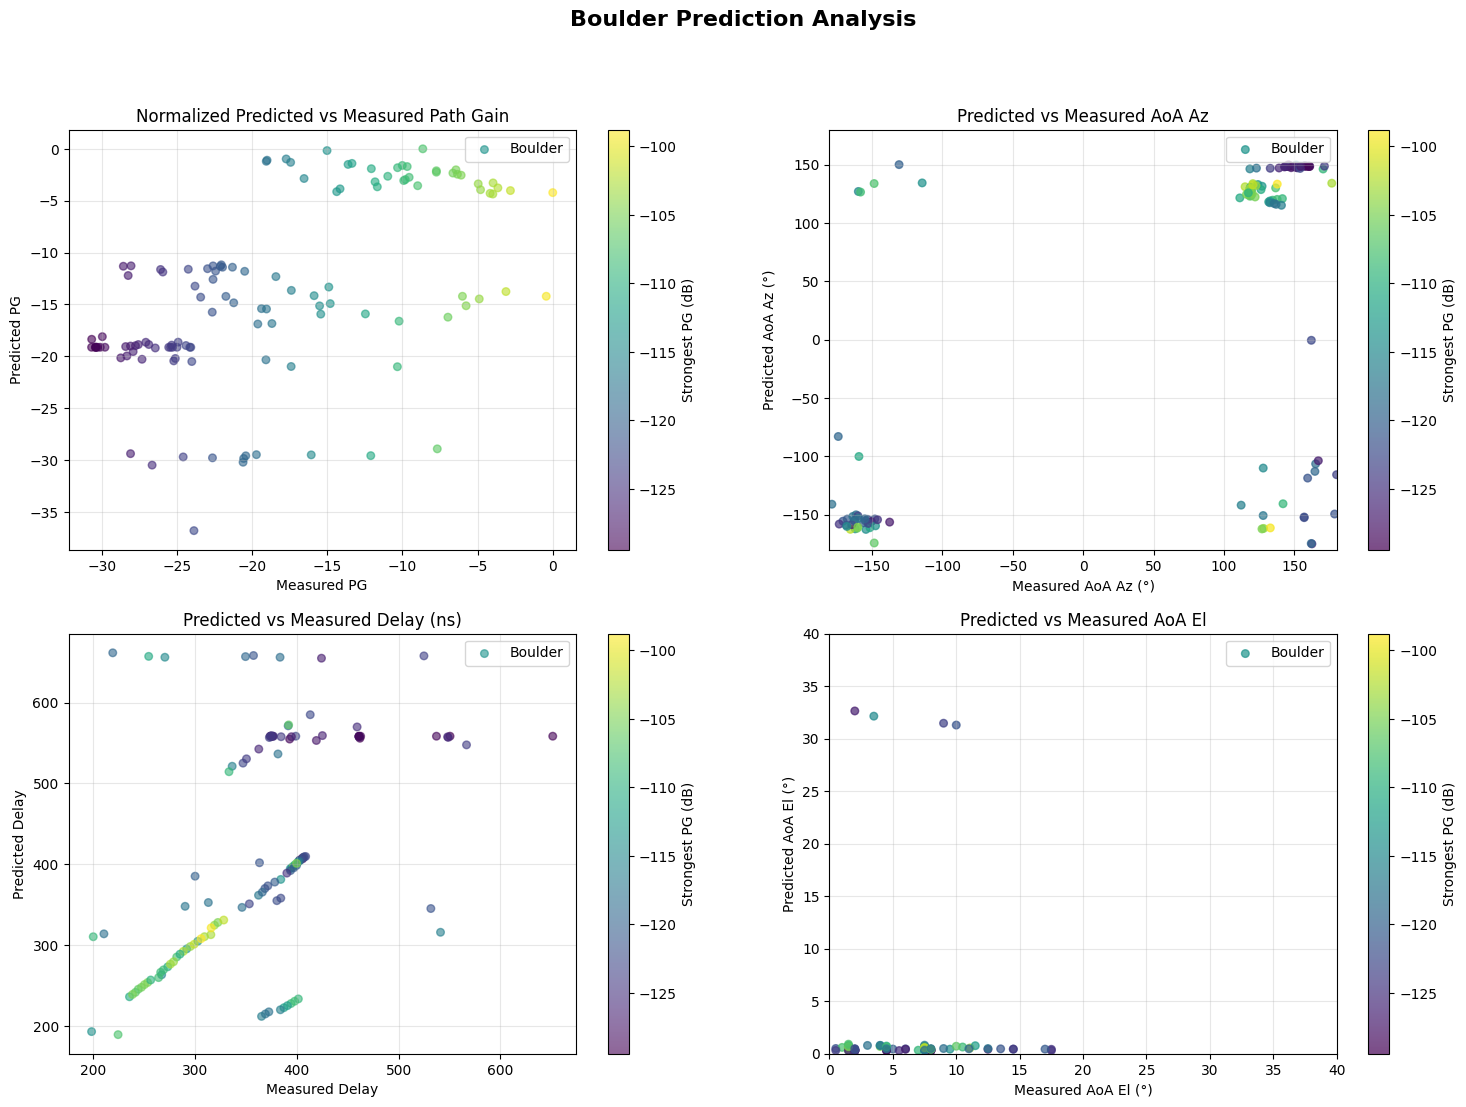

In [136]:
# Generating comparison plots with the color map being actual path gain results
# Perfect prediction lines can be adjusted based on whether measurement is NLOS or LOS

pg_colors = comparison_df['Strongest PG (dB)'] 

# Create Plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Boulder Prediction Analysis', fontsize=16, fontweight='bold')

# 1. Scatter plot: Path Gain
sc1 = axes[0, 0].scatter(comparison_df['PG Norm (dB)'], 
                         comparison_df['Sionna PG Norm (dB)'],
                         c=pg_colors,
                         cmap='viridis',  
                         alpha=0.6, 
                         s=30, 
                         label='Boulder')
# axes[0, 0].plot([-30, 0], [-30, 0], 'r--', label='Perfect Prediction')
axes[0, 0].set_xlabel('Measured PG')
axes[0, 0].set_ylabel('Predicted PG')
axes[0, 0].set_title('Normalized Predicted vs Measured Path Gain')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(sc1, ax=axes[0, 0])
cbar1.set_label('Strongest PG (dB)')

# 2. Scatter plot: Delay
sc2 = axes[1, 0].scatter(comparison_df['Delay (ns)'], 
                         comparison_df['Sionna Delay (ns)'], 
                         c=pg_colors,
                         cmap='viridis', 
                         alpha=0.6, 
                         s=30, 
                         label='Boulder')
# axes[1, 0].plot([200, 600], [200, 600], 'r--', label='Perfect Prediction')
axes[1, 0].set_xlabel('Measured Delay')
axes[1, 0].set_ylabel('Predicted Delay')
axes[1, 0].set_title('Predicted vs Measured Delay (ns)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=axes[1, 0])
cbar2.set_label('Strongest PG (dB)')

# 3. Scatter plot: AoA Az with colormap
sc3 = axes[0, 1].scatter(
    comparison_df['AoA Az'], 
    comparison_df['Sionna AoA Az'], 
    c=pg_colors,
    cmap='viridis',   # choose your colormap here
    alpha=0.7, 
    s=30,
    label='Boulder'
)
# axes[0, 1].plot([100, 180], [100, 180], 'r--', label='Perfect Prediction')
axes[0, 1].set_xlim(-180, 180)
axes[0, 1].set_ylim(-180, 180)
axes[0, 1].set_xlabel('Measured AoA Az (°)')
axes[0, 1].set_ylabel('Predicted AoA Az (°)')
axes[0, 1].set_title('Predicted vs Measured AoA Az')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
cbar3 = plt.colorbar(sc3, ax=axes[0, 1])
cbar3.set_label('Strongest PG (dB)')

# 4. Scatter plot: AoA El with colormap
sc4 = axes[1, 1].scatter(
    comparison_df['AoA El'], 
    comparison_df['Sionna AoA El'], 
    c=pg_colors,
    cmap='viridis', 
    alpha=0.7, 
    s=30,
    label='Boulder'
)
# axes[1, 1].plot([0, 45], [0, 45], 'r--', label='Perfect Prediction')
axes[1, 1].set_xlim(0, 40)
axes[1, 1].set_ylim(0, 40)
axes[1, 1].set_xlabel('Measured AoA El (°)')
axes[1, 1].set_ylabel('Predicted AoA El (°)')
axes[1, 1].set_title('Predicted vs Measured AoA El')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
cbar4 = plt.colorbar(sc4, ax=axes[1, 1])
cbar4.set_label('Strongest PG (dB)')



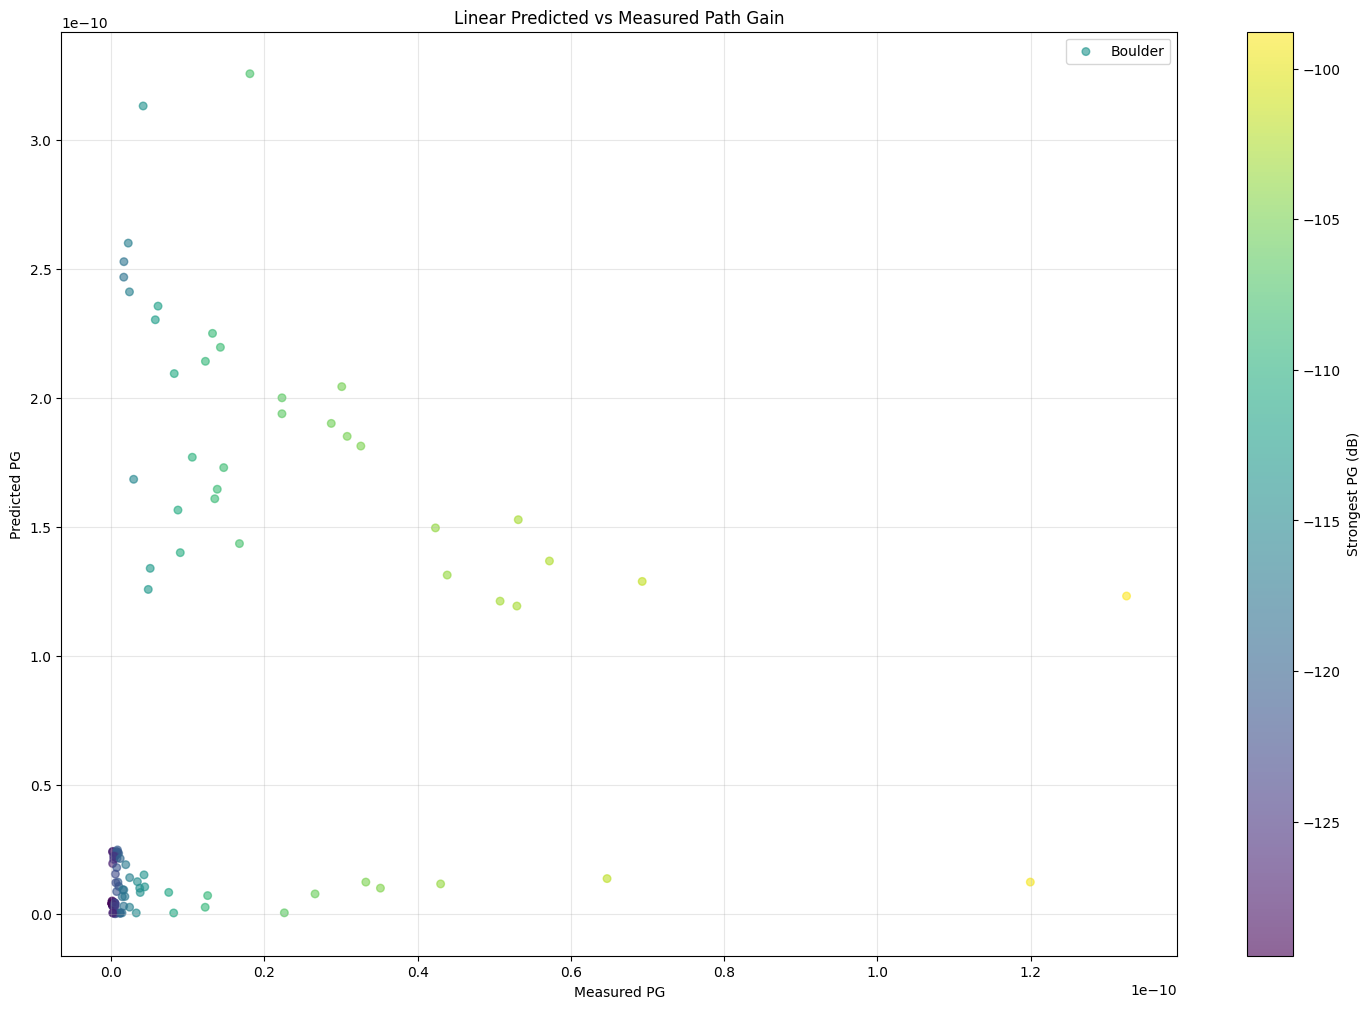

In [137]:
# Linear scatter plot
fig, axes = plt.subplots(1, 1, figsize=(18, 12))
sc = axes.scatter(linear(comparison_df['Strongest PG (dB)']), 
                         linear(comparison_df['Strongest Sionna PG (dB)']),
                         c=pg_colors,
                         cmap='viridis',  
                         alpha=0.6, 
                         s=30, 
                         label='Boulder')
#axes.plot([-30, 0], [-30, 0], 'r--', label='Perfect Prediction')
axes.set_xlabel('Measured PG')
axes.set_ylabel('Predicted PG')
axes.set_title('Linear Predicted vs Measured Path Gain')
axes.legend()
axes.grid(True, alpha=0.3)
cbar1 = plt.colorbar(sc, ax=axes)
cbar1.set_label('Strongest PG (dB)')


In [138]:
comparison_df['PG Absolute Error'] = np.abs(comparison_df['PG Norm (dB)'] - comparison_df['Sionna PG Norm (dB)'])
comparison_df.head(10)

rx_id  Strongest PG (dB)  AoA El      AoA Az  Delay (ns)  \
0  2266        -113.576847    -4.5  151.193053     384.200   
1  2267        -113.790257    -8.0 -114.186839     198.300   
2  2265        -119.996821     5.0 -130.586141     300.000   
3  2264        -108.997424   -12.5  141.897620     199.925   
4  2248        -121.425873     0.5  178.509260     531.675   
5  2249        -121.410247    10.0  159.376149     357.400   
6  2261        -119.375509    -7.5 -173.732288     219.100   
7  2263        -118.149849    -2.5 -178.271235     210.425   
8  2262        -116.164435    -2.0  112.180050     541.175   
9  2198        -124.321039    -6.5  154.834380     374.450   

   Strongest Sionna PG (dB)  Sionna AoA El  Sionna AoA Az  Sionna Delay (ns)  \
0               -109.797409       0.451080     149.791840         381.325470   
1                -95.041840       0.890289     134.412598         193.210281   
2               -109.717896       0.446411     150.092133         385.318146   
3               -111.489929       0.553993    -140.602448         310.491119   
4               -110.621231       0.498070    -149.408066         345.355347   
5               -124.666214      31.301022    -118.601685         658.132202   
6               -125.093155      30.062462     -82.941071         661.473755   
7               -110.280792       0.547699    -140.996094         314.058105   
8               -108.521500       0.544334    -141.799866         316.002869   
9               -114.007278       0.308052     148.551208         558.372437   

  Sionna Ray Type  PG Norm (dB)  Sionna PG Norm (dB)  PG Absolute Error  
0         DIFFUSE    -14.800108           -14.925575           0.125468  
1         DIFFUSE    -15.013517            -0.170002          14.843516  
2         DIFFUSE    -21.220081           -14.846058           6.374023  
3         DIFFUSE    -10.220685           -16.618090           6.397405  
4        SPECULAR    -22.649134           -15.749397           6.899737  
5         DIFFUSE    -22.633507           -29.794378           7.160871  
6         DIFFUSE    -20.598769           -30.221319           9.622550  
7         DIFFUSE    -19.373109           -15.408955           3.964155  
8         DIFFUSE    -17.387695           -13.649664           3.738031  
9         DIFFUSE    -25.544300           -19.135447           6.408853

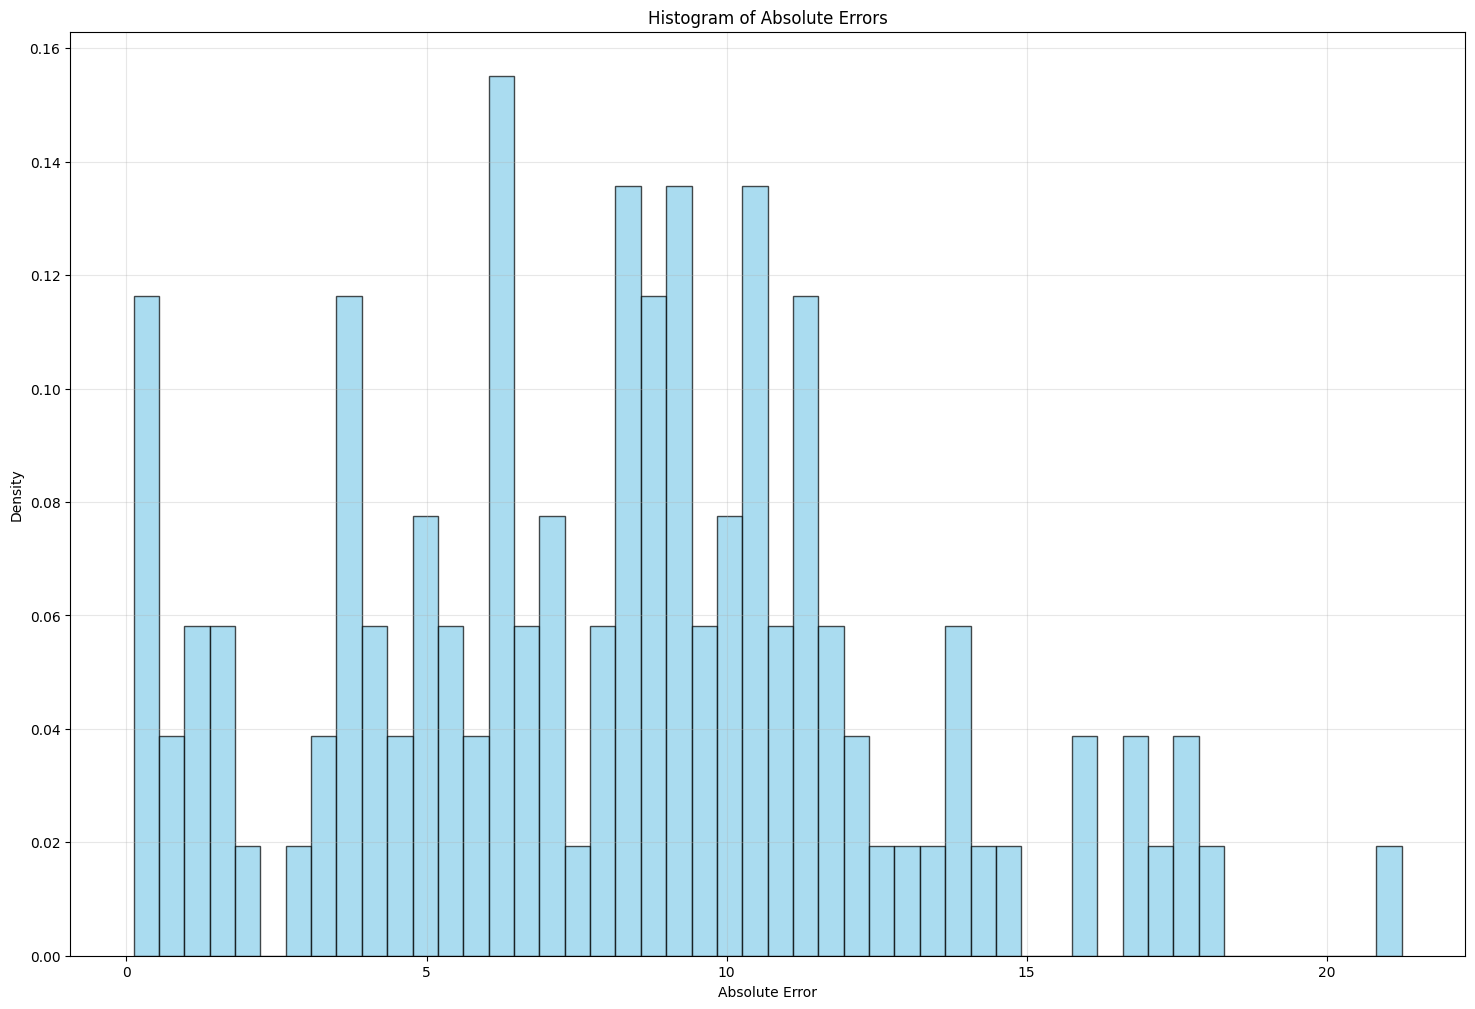

In [139]:
fig, axes = plt.subplots(1, 1, figsize=(18, 12))
axes.hist(comparison_df['PG Absolute Error'], bins=50, alpha=0.7, 
                color='skyblue', edgecolor='black', density=True)
axes.set_xlabel('Absolute Error')
axes.set_ylabel('Density')
axes.set_title('Histogram of Absolute Errors')
axes.grid(True, alpha=0.3)

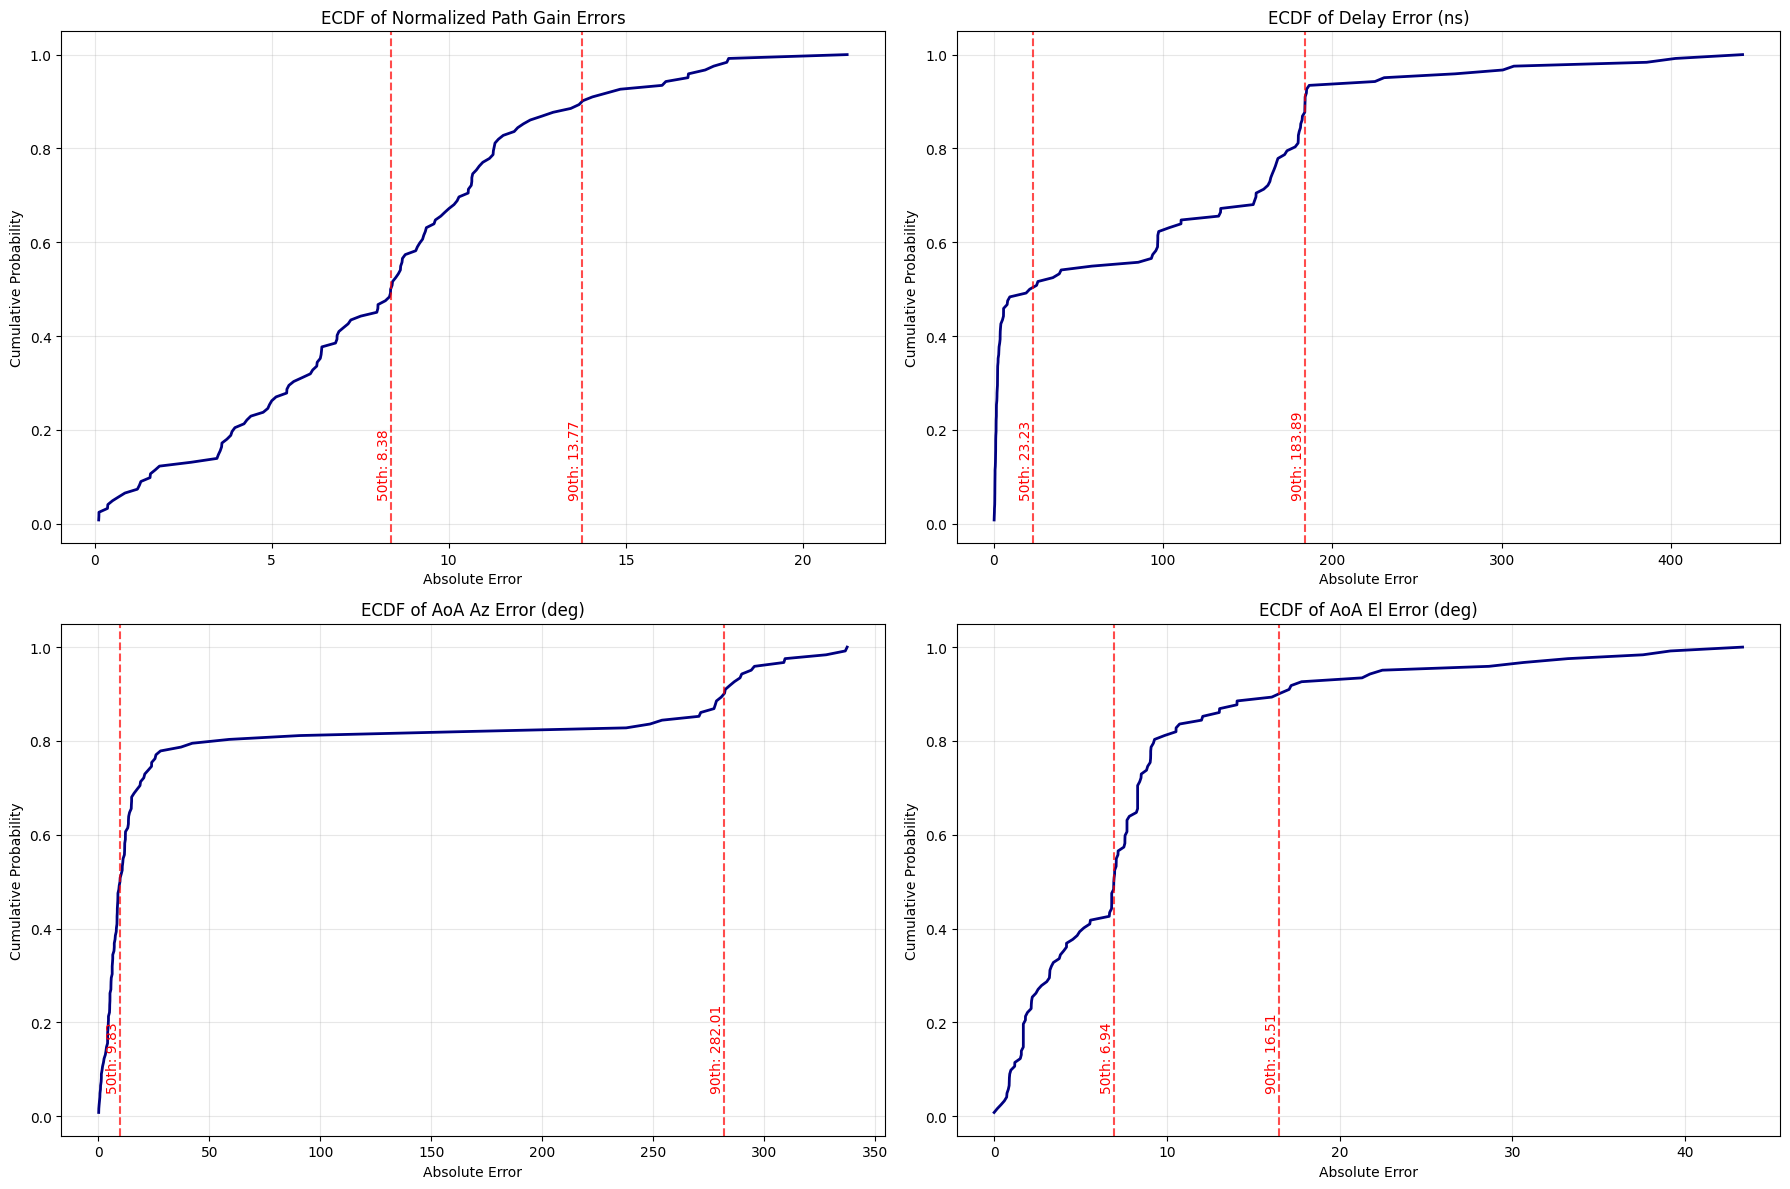

In [140]:
# Function to plot ecdf and percentiles
def plot_ecdf_with_percentiles(ax, errors, title, xlabel, percentiles=[50, 90]):
    sorted_errors = np.sort(errors)
    ecdf_y = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

    # Plot ECDF
    ax.plot(sorted_errors, ecdf_y, linewidth=2, color='navy')

    # Plot percentile lines
    for p in percentiles:
        val = np.percentile(sorted_errors, p)
        ax.axvline(val, linestyle='--', color='red', alpha=0.7)
        ax.text(val, 0.05, f'{p}th: {val:.2f}', rotation=90, va='bottom', ha='right', color='red')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Path Gain Error
plot_ecdf_with_percentiles(
    axes[0,0],
    comparison_df['PG Absolute Error'],
    'ECDF of Normalized Path Gain Errors',
    'Absolute Error'
)

# 2. Delay Error
plot_ecdf_with_percentiles(
    axes[0,1],
    np.abs(comparison_df['Sionna Delay (ns)'] - comparison_df['Delay (ns)']),
    'ECDF of Delay Error (ns)',
    'Absolute Error'
)

# 3. AoA Az Error
plot_ecdf_with_percentiles(
    axes[1,0],
    np.abs(comparison_df['Sionna AoA Az'] - comparison_df['AoA Az']),
    'ECDF of AoA Az Error (deg)',
    'Absolute Error'
)

# 4. AoA El Error
plot_ecdf_with_percentiles(
    axes[1,1],
    np.abs(comparison_df['Sionna AoA El'] - comparison_df['AoA El']),
    'ECDF of AoA El Error (deg)',
    'Absolute Error'
)

plt.tight_layout()
plt.show()


In [141]:
min_error_idx = comparison_df['PG Absolute Error'].idxmin()
min_error_row = comparison_df.loc[min_error_idx]
min_rx_id = min_error_row['rx_id']
min_val = min_error_row['PG Absolute Error']


max_error_idx = comparison_df['PG Absolute Error'].idxmax()
max_error_row = comparison_df.loc[max_error_idx]
max_rx_id = max_error_row['rx_id']
max_val = max_error_row['PG Absolute Error']

extremes_rx_id = [min_rx_id, max_rx_id]

print(f"Min Absolute Error (dB): {min_val}")
print(f"Max Absolute Error (dB): {max_val}")

Min Absolute Error (dB): 0.11837785665525757
Max Absolute Error (dB): 21.248397135721273


Generating comparison profiles for the rx with the least and most amount of path gain error.

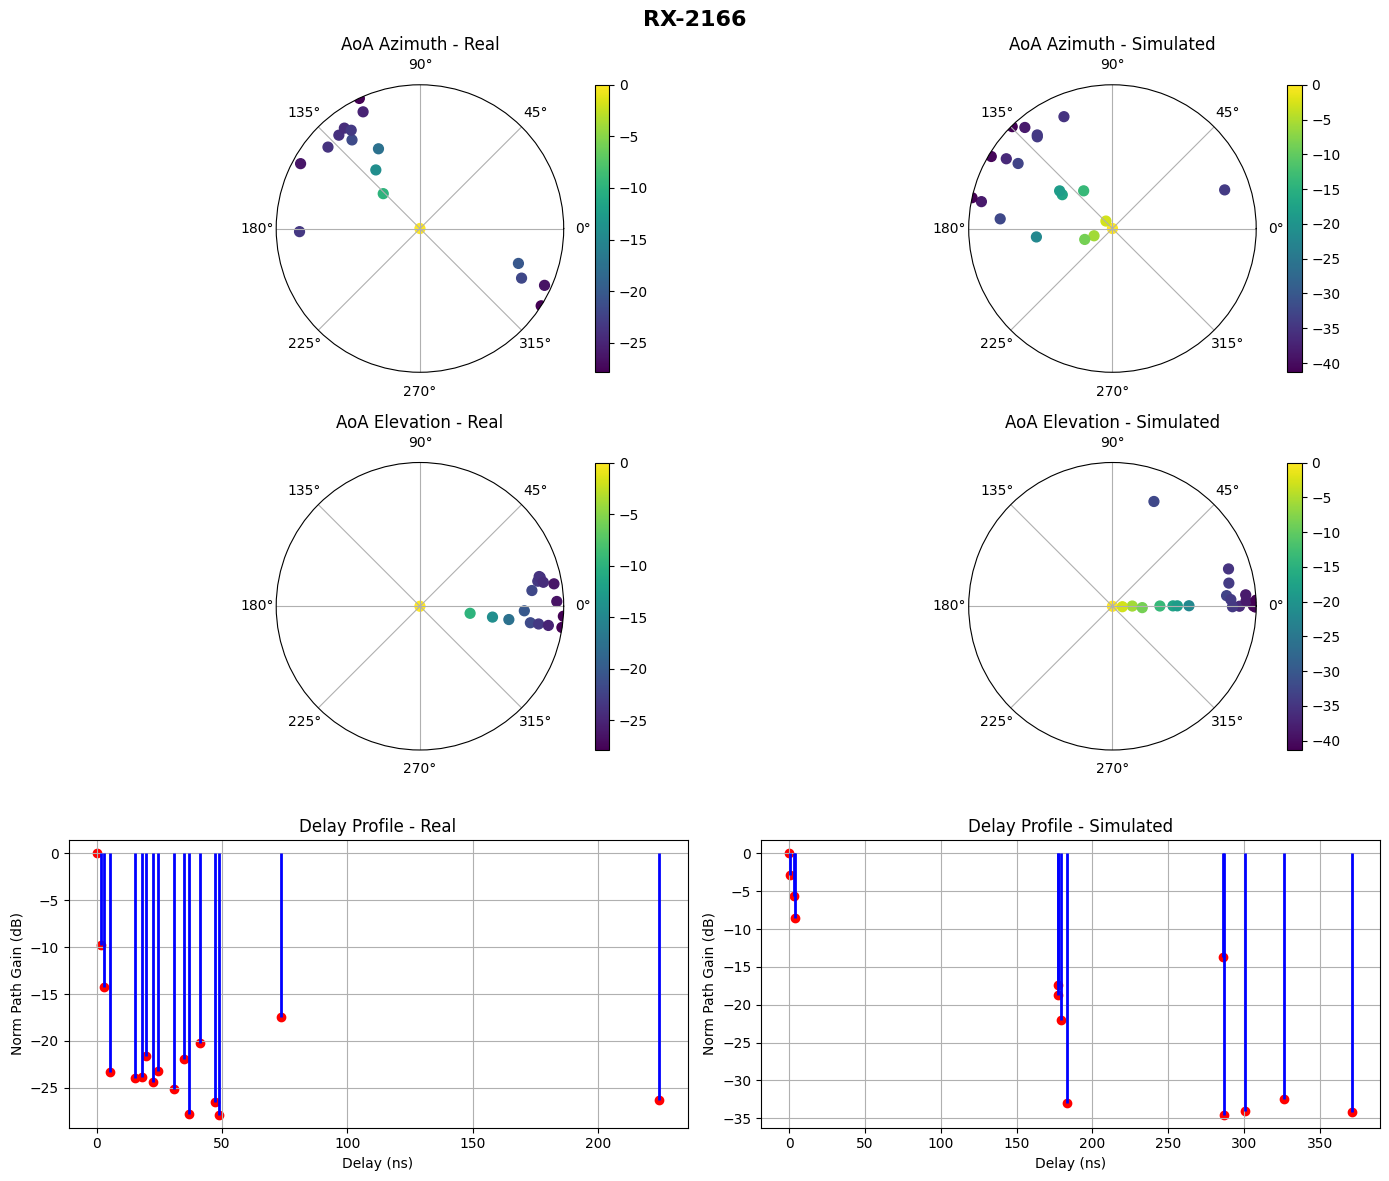

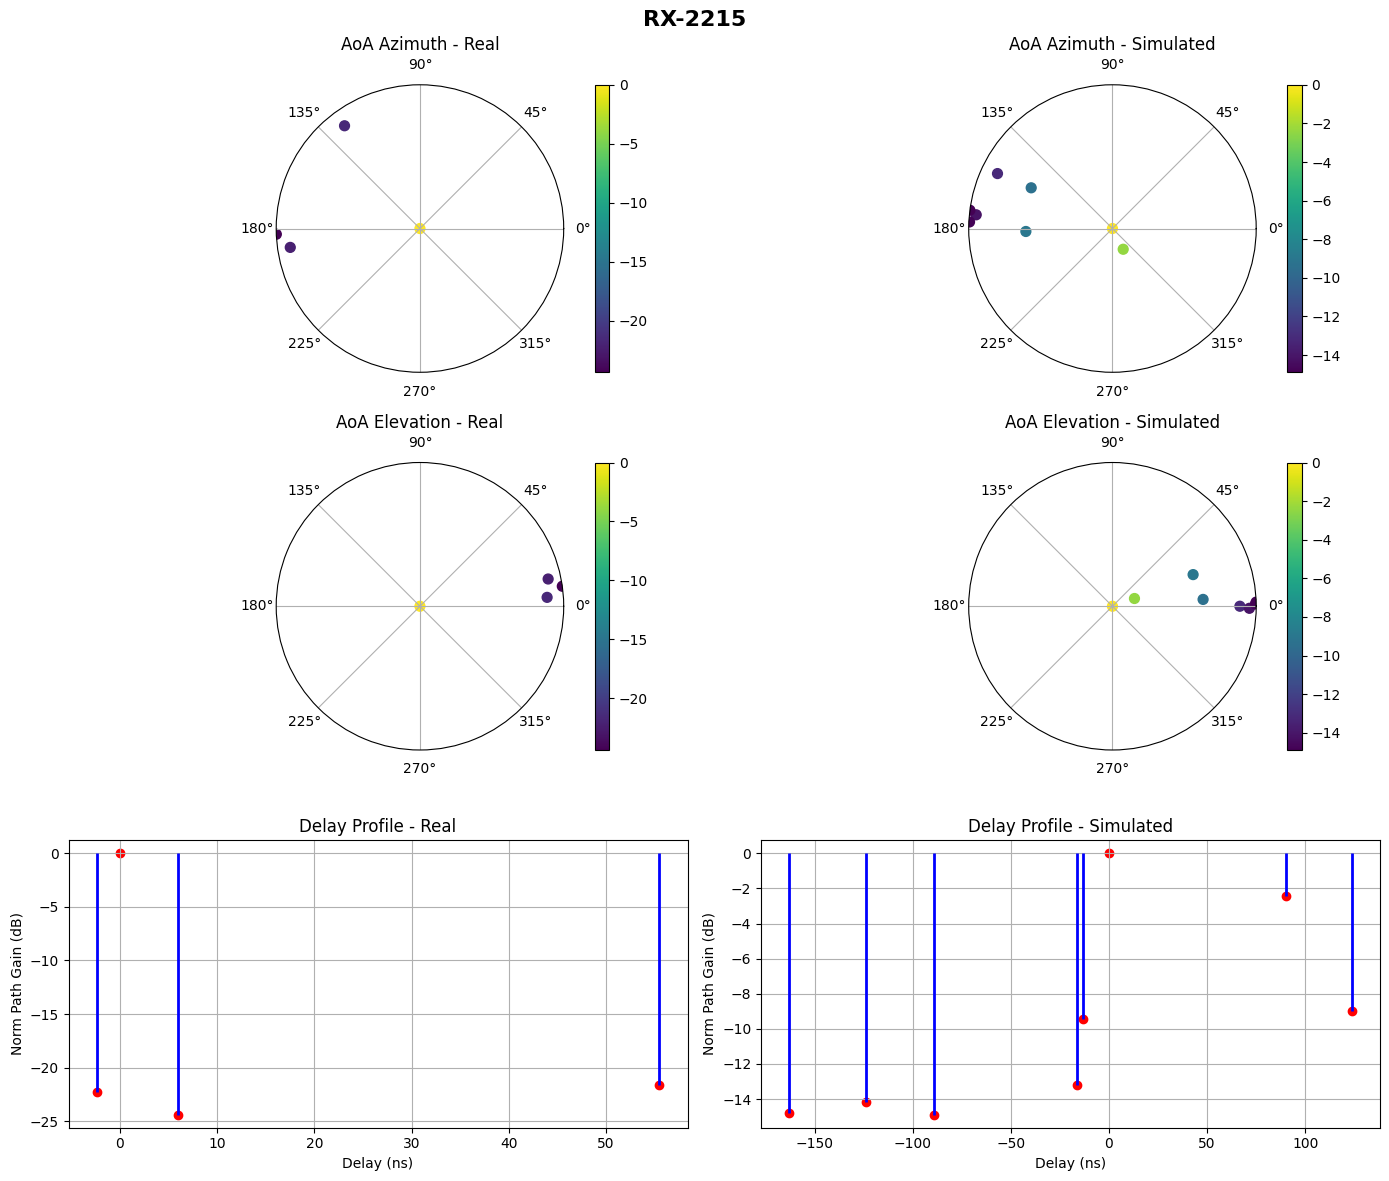

In [142]:
for rx_id in extremes_rx_id:
    merged_df_row = merged_df[merged_df['mea_idx'] == rx_id]
    if merged_df_row['is_outdoor'].iloc[0] == True:
        tmp_tau = merged_df_row["MPC_params_sector01"].values[0][:, 0]
        tmp_aoa_az = merged_df_row["MPC_params_sector01"].values[0][:, 1]
        tmp_aoa_el = merged_df_row["MPC_params_sector01"].values[0][:, 2]
        tmp_path_gain = -1.0*merged_df_row["MPC_params_sector01"].values[0][:, 3]

        strongest_pg_idx = np.argmax(tmp_path_gain)

        # Get Sionna results
        tmp_df = df[df["rx_id"] == rx_id]
        tmp_tau_sionna = (tmp_df["tau"].values * 1e9)  # Convert to nsec
        tmp_aoa_az_sionna = (90 - (tmp_df["phi_r"].values * 180 / np.pi)) % 360
        tmp_aoa_el_sionna = (90 - (tmp_df["theta_r"].values * 180 / np.pi)) % 360
        tmp_path_gain_sionna = 10 * np.log10(np.abs(tmp_df["a"].values)**2)
        tmp_ray_type_sionna = tmp_df["type"]
        
        # Apply threshold
        threshold_value = -140
        mask = tmp_path_gain_sionna >= threshold_value

        # Apply mask to all arrays
        tmp_tau_sionna = tmp_tau_sionna[mask]
        tmp_aoa_az_sionna = tmp_aoa_az_sionna[mask]
        tmp_aoa_el_sionna = tmp_aoa_el_sionna[mask]
        tmp_path_gain_sionna = tmp_path_gain_sionna[mask]

        tmp_pg_norm = normalize(tmp_path_gain)

        if len(tmp_path_gain_sionna) > 0:
            
            threshold_pg_sionna_norm = normalize(np.array(list(tmp_path_gain_sionna)))
            
            # Plot Comparisons
            compare_real_vs_sionna(
                    tmp_aoa_az, tmp_aoa_az_sionna,
                    tmp_aoa_el, tmp_aoa_el_sionna,
                    tmp_tau, tmp_tau_sionna,
                    tmp_pg_norm, threshold_pg_sionna_norm,
                    rx_id,
                    -35 # Delay norm power threshold value
            )